# Colab  idiosyncrasies

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
cd "/content/drive/My Drive/NeuroAttention/speechmodeltutorial"

/content/drive/.shortcut-targets-by-id/1hH3_K18Zg77XlKWSQi5fhRr_y7nbne-Y/NeuroAttention/speechmodeltutorial


# Imports

In [0]:
# Run this cell if your computer has a 'retina' display. It will make the figures look much nicer.
%config InlineBackend.figure_format = 'retina'

In [0]:
from matplotlib.pyplot import figure, cm
import numpy as np
import logging
logging.basicConfig(level=logging.DEBUG)

In [5]:
!pip install transformers
!pip install pytorch-pretrained-bert

In [6]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch

from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM
import transformers as ppb # pytorch transformers

INFO:pytorch_pretrained_bert.modeling:Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
INFO:transformers.file_utils:PyTorch version 1.4.0 available.
DEBUG:tensorflow:Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
INFO:transformers.file_utils:TensorFlow version 2.2.0-rc3 available.


In [0]:
# !git clone https://github.com/HuthLab/speechmodeltutorial

In [8]:
!git clone https://github.com/gallantlab/pycortex.git

fatal: destination path 'pycortex' already exists and is not an empty directory.


In [9]:
cd pycortex

/content/drive/.shortcut-targets-by-id/1hH3_K18Zg77XlKWSQi5fhRr_y7nbne-Y/NeuroAttention/speechmodeltutorial/pycortex


In [10]:
!python setup.py install

running install
running build
running build_py
package init file 'cortex/tests/__init__.py' not found (or not a regular file)
running egg_info
writing pycortex.egg-info/PKG-INFO
writing dependency_links to pycortex.egg-info/dependency_links.txt
writing requirements to pycortex.egg-info/requires.txt
writing top-level names to pycortex.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'pycortex.egg-info/SOURCES.txt'
running build_ext
running install_lib
running install_egg_info
removing '/usr/local/lib/python3.6/dist-packages/pycortex-1.2.dev0-py3.6.egg-info' (and everything under it)
Copying pycortex.egg-info to /usr/local/lib/python3.6/dist-packages/pycortex-1.2.dev0-py3.6.egg-info
running install_scripts


In [11]:
!pip install wget

In [12]:
cd "/content/drive//My Drive/NeuroAttention/speechmodeltutorial"

/content/drive/.shortcut-targets-by-id/1hH3_K18Zg77XlKWSQi5fhRr_y7nbne-Y/NeuroAttention/speechmodeltutorial


# Sematic Model

In [13]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

# Using DistillBert here to get a quick baseline
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

model = model_class.from_pretrained(pretrained_weights).to(device)

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): s3.amazonaws.com:443
DEBUG:urllib3.connectionpool:https://s3.amazonaws.com:443 "HEAD /models.huggingface.co/bert/distilbert-base-uncased-config.json HTTP/1.1" 200 0
INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/distilbert-base-uncased-config.json from cache at /root/.cache/torch/transformers/a41e817d5c0743e29e86ff85edc8c257e61bc8d88e4271bb1b243b6e7614c633.8949e27aafafa845a18d98a0e3a88bc2d248bbc32a1b75947366664658f23b1c
INFO:transformers.configuration_utils:Model config DistilBertConfig {
  "_num_labels": 2,
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "bad_words_ids": null,
  "bos_token_id": null,
  "decoder_start_token_id": null,
  "dim": 768,
  "do_sample": false,
  "dropout": 0.1,
  "early_stopping": false,
  "eos_token_id": null,
  "finetuning_task": null,
  "hidden_dim": 3072,
  "id2lab

# Load Stimulus Data

In [0]:

# These are lists of the stories
# Rstories are the names of the training (or Regression) stories, which we will use to fit our models
Rstories = ['alternateithicatom', 'avatar', 'howtodraw', 'legacy', 
            'life', 'myfirstdaywiththeyankees', 'naked', 
            'odetostepfather', 'souls', 'undertheinfluence']

# Pstories are the test (or Prediction) stories (well, story), which we will use to test our models
Pstories = ['wheretheressmoke']

allstories = Rstories + Pstories

# Load TextGrids
from stimulus_utils import load_grids_for_stories
grids = load_grids_for_stories(allstories)

# Load TRfiles
from stimulus_utils import load_generic_trfiles
trfiles = load_generic_trfiles(allstories)

# Make word and phoneme datasequences
from dsutils import make_word_ds, make_phoneme_ds
wordseqs = make_word_ds(grids, trfiles) # dictionary of {storyname : word DataSequence}
phonseqs = make_phoneme_ds(grids, trfiles) # dictionary of {storyname : phoneme DataSequence}

Before going on, let's play with the DataSequences a bit, both so you can see what the data structure looks like, and also so you can see what the stimuli look like.

In [15]:
naked = wordseqs["naked"]
# The DataSequence stores a lot of information
# naked.data is a list of all the words in the story
print ("There are  words in the story called 'naked'", len(naked.data))

There are  words in the story called 'naked' 3218


In [16]:
# We can print out the first 100 words like this
print (naked.data[:100])
# or, if you want it to be more readable, like this
print (" ".join(naked.data[:100]))

['i', 'grew', 'up', 'in', 'a', 'really', 'small', 'town', 'in', 'alabama', 'and', 'my', 'sister', 'was', 'and', 'is', 'to', 'this', 'day', 'a', 'remarkably', 'beautiful', 'woman', 'and', 'i', 'was', 'always', 'really', 'good', 'in', 'school', 'so', 'it', 'fell', 'into', 'this', 'pattern', 'with', 'my', 'family', 'where', 'people', 'would', 'say', 'things', 'like', "she's", 'the', 'beauty', "you're", 'the', 'brain', 'and', 'among', 'my', 'almost', 'anorexically', 'petite', 'friends', 'growing', 'up', 'at', 'five', 'foot', 'five', 'a', 'hundred', 'and', 'forty', 'pounds', 'it', 'was', 'universally', 'acknowledged', 'that', 'i', 'was', 'the', 'fat', 'one', 'the', 'whole', 'thing', 'really', 'started', 'in', 'first', 'grade', 'i', 'have', 'to', 'say', 'there', 'was', 'a', 'weigh', 'in', 'in', 'school', 'my']
i grew up in a really small town in alabama and my sister was and is to this day a remarkably beautiful woman and i was always really good in school so it fell into this pattern with m

In [17]:
# the datasequence also stores when exactly each word was spoken (this time corresponds to the middle of each word)
print (naked.data_times[:10])

[0.19705215 0.38662132 0.59614512 0.75675316 0.85153774 1.02517007
 1.32947846 1.6537415  1.84829932 2.19251701]


In [18]:
# and it also stores the time of the middle of each fMRI acquisition (each acqusition takes 2.0045 seconds)
# these times are relative to story start, so the fMRI scan started 10 seconds before the story
print (naked.tr_times[:10])

[-9.02085041 -7.04012641 -5.03223841 -3.03203841 -1.02396941  0.98489959
  2.98378359  4.99206359  6.99189259  8.99996159]


In [19]:
# and it also makes it easy to, for example, find the words that were spoken during each fMRI acquisition
# (the first few are empty because they came before the story started)
print (naked.chunks()[:10])

[array([], dtype='<U15'), array([], dtype='<U15'), array([], dtype='<U15'), array([], dtype='<U15'), array([], dtype='<U15'), array(['i', 'grew', 'up', 'in', 'a', 'really', 'small', 'town', 'in',
       'alabama'], dtype='<U15'), array(['and', 'my', 'sister'], dtype='<U15'), array(['was', 'and', 'is', 'to', 'this', 'day', 'a', 'remarkably'],
      dtype='<U15'), array(['beautiful', 'woman', 'and', 'i', 'was', 'always'], dtype='<U15'), array(['really', 'good', 'in', 'school'], dtype='<U15')]


# Projecting the Stimuli into the Semantic Space

In [0]:
# get the word embeddings and few other things

In [21]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Takes Dataset and returns all of the necessary variables to feed into BERT
def dataProcessingEmbedding(Dataset):
  tokenized_text = []
  indexed_tokens = []
  segments_ids = []
  marked_text_lis = []
  error_lis = []
  for i in range(0,len(Dataset)):
    if i<=20:
      marked_text = "[CLS] "+str(Dataset[0:i+20])+" [SEP]"
    else:
      marked_text = "[CLS] "+str(Dataset[i-10:i+10])+" [SEP]" # a window of previous 20 words. For the first 20 words isn't as much words as possible. hence the very last first one is just a single word. 

    try:
      # Tokenize our sentence with the BERT tokenizer.
        tokens = tokenizer.tokenize(marked_text)
        marked_text_lis.append(marked_text)
        tokenized_text.append(tokens)
        indexed_tokens.append(tokenizer.convert_tokens_to_ids(tokens))
        segments_ids.append([1] * len(tokens))
    except:
        error_lis.append(i)

  return tokenized_text, indexed_tokens, segments_ids, marked_text_lis

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): s3.amazonaws.com:443
DEBUG:urllib3.connectionpool:https://s3.amazonaws.com:443 "HEAD /models.huggingface.co/bert/bert-base-uncased-vocab.txt HTTP/1.1" 200 0
INFO:pytorch_pretrained_bert.tokenization:loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /root/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


In [22]:
type(wordseqs['naked'].data)

list

In [23]:
"[CLS] "+str(wordseqs['naked'].data[0:2])+" [SEP]"

"[CLS] ['i', 'grew'] [SEP]"

In [0]:
tokenized_text_all = {}
indexed_tokens_all = {}
segments_ids_all = {}
marked_text_lis_all = {}
for story in allstories:
  tokenized_text, indexed_tokens, segments_ids, marked_text_lis = dataProcessingEmbedding(wordseqs[story].data)
  tokenized_text_all[story]=tokenized_text
  indexed_tokens_all[story]=indexed_tokens
  segments_ids_all[story]=segments_ids
  marked_text_lis_all[story]=marked_text_lis



In [25]:
#though you have made it at a word level, those words might not exist in bert and are hence broken down! hence need not be three!
for el in indexed_tokens_all['naked'][0:5]:
  print(el)

[101, 1031, 1005, 1045, 1005, 1010, 1005, 3473, 1005, 1010, 1005, 2039, 1005, 1010, 1005, 1999, 1005, 1010, 1005, 1037, 1005, 1010, 1005, 2428, 1005, 1010, 1005, 2235, 1005, 1010, 1005, 2237, 1005, 1010, 1005, 1999, 1005, 1010, 1005, 6041, 1005, 1010, 1005, 1998, 1005, 1010, 1005, 2026, 1005, 1010, 1005, 2905, 1005, 1010, 1005, 2001, 1005, 1010, 1005, 1998, 1005, 1010, 1005, 2003, 1005, 1010, 1005, 2000, 1005, 1010, 1005, 2023, 1005, 1010, 1005, 2154, 1005, 1010, 1005, 1037, 1005, 1033, 102]
[101, 1031, 1005, 1045, 1005, 1010, 1005, 3473, 1005, 1010, 1005, 2039, 1005, 1010, 1005, 1999, 1005, 1010, 1005, 1037, 1005, 1010, 1005, 2428, 1005, 1010, 1005, 2235, 1005, 1010, 1005, 2237, 1005, 1010, 1005, 1999, 1005, 1010, 1005, 6041, 1005, 1010, 1005, 1998, 1005, 1010, 1005, 2026, 1005, 1010, 1005, 2905, 1005, 1010, 1005, 2001, 1005, 1010, 1005, 1998, 1005, 1010, 1005, 2003, 1005, 1010, 1005, 2000, 1005, 1010, 1005, 2023, 1005, 1010, 1005, 2154, 1005, 1010, 1005, 1037, 1005, 1010, 1005, 17431

Convert Indexed Tokens to Tensors

In [0]:
# Convert inputs to PyTorch tensors, so it's usable
def convertTokens_Tensors(indexed_tokens,segments_ids):
  pad = len(max(indexed_tokens, key=len))
  indexed_tokens_pad = np.array([i + [0]*(pad-len(i)) for i in indexed_tokens])
  segments_ids_pad = np.array([i + [1]*(pad-len(i)) for i in segments_ids])

  tokens_tensor = torch.Tensor(indexed_tokens_pad)
  segments_tensors = torch.tensor(segments_ids_pad)

  return tokens_tensor, segments_tensors


In [0]:
tokens_tensor_all = {}
segments_tensors_all = {}

for story in allstories:
  tokens_tensor, segments_tensors = convertTokens_Tensors(indexed_tokens_all[story],segments_ids_all[story])
  tokens_tensor_all[story]=tokens_tensor
  segments_tensors_all[story]=segments_tensors


In [0]:
semanticseqs = {}
for story in allstories:
  with torch.no_grad():
      token_inputs = tokens_tensor_all[story].to(torch.int64).to(device)
      attn_masks = segments_tensors_all[story].to(torch.int64).to(device)
      last_hidden_states = model(token_inputs, attention_mask=attn_masks)
  semanticseqs[story] = last_hidden_states[0][:,0,:].numpy().cpu()

In [0]:
import pickle
pickle.dump( semanticseqs, open( "semanticseqs.p", "wb" ) )

In [30]:

# take a look at the projected stimuli
naked_proj = semanticseqs["naked"]

print (naked_proj.shape) # prints the shape of 'data' as (rows, columns)
print (naked_proj[:10]) # print the first 10 rows (this will be truncated)

(3218, 768)
[[ 0.07257143 -0.08344063  0.1041109  ...  0.08015393  0.67658174
   0.0870507 ]
 [ 0.052775   -0.06287722  0.10527322 ...  0.0814456   0.6899679
   0.09664761]
 [ 0.02930616 -0.07073375  0.10304114 ...  0.07493959  0.68509096
   0.09939934]
 ...
 [ 0.02851312 -0.04471471  0.18263799 ...  0.10711837  0.6472046
   0.23207183]
 [ 0.03225519 -0.04004955  0.20732602 ...  0.12147795  0.62412333
   0.24048881]
 [ 0.02773329 -0.02433216  0.23497695 ...  0.13341354  0.58359873
   0.24386881]]


In [31]:
# lanczos interpolation
from interpdata import sincinterp2D, gabor_xfm2D, lanczosinterp2D

downsampled_semanticseqs = dict() # dictionary to hold downsampled stimuli
for story in allstories:
  print(semanticseqs[story].shape)
  print(wordseqs[story].data_times.shape)
  print(wordseqs[story].tr_times.shape)
  downsampled_semanticseqs[story]=lanczosinterp2D(semanticseqs[story], wordseqs[story].data_times, wordseqs[story].tr_times) 

(2174, 768)
(2174,)
(358,)
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
(1469, 768)
(1469,)
(382,)
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
(1964, 768)
(1964,)
(369,)
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
(1893, 768)
(1893,)
(415,)
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
(2209, 768)
(2209,)
(445,)
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
(2786, 768)
(2786,)
(373,)
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
(3218, 768)
(3218,)
(437,)
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
(2675, 768)
(2675,)
(419,)
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
(1868, 768)
(1868,)
(370,)
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
(1641, 768)
(1641,)
(319,)
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
(1839, 768)
(1839,)
(306,)
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


Visualizing the downsampling

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) i

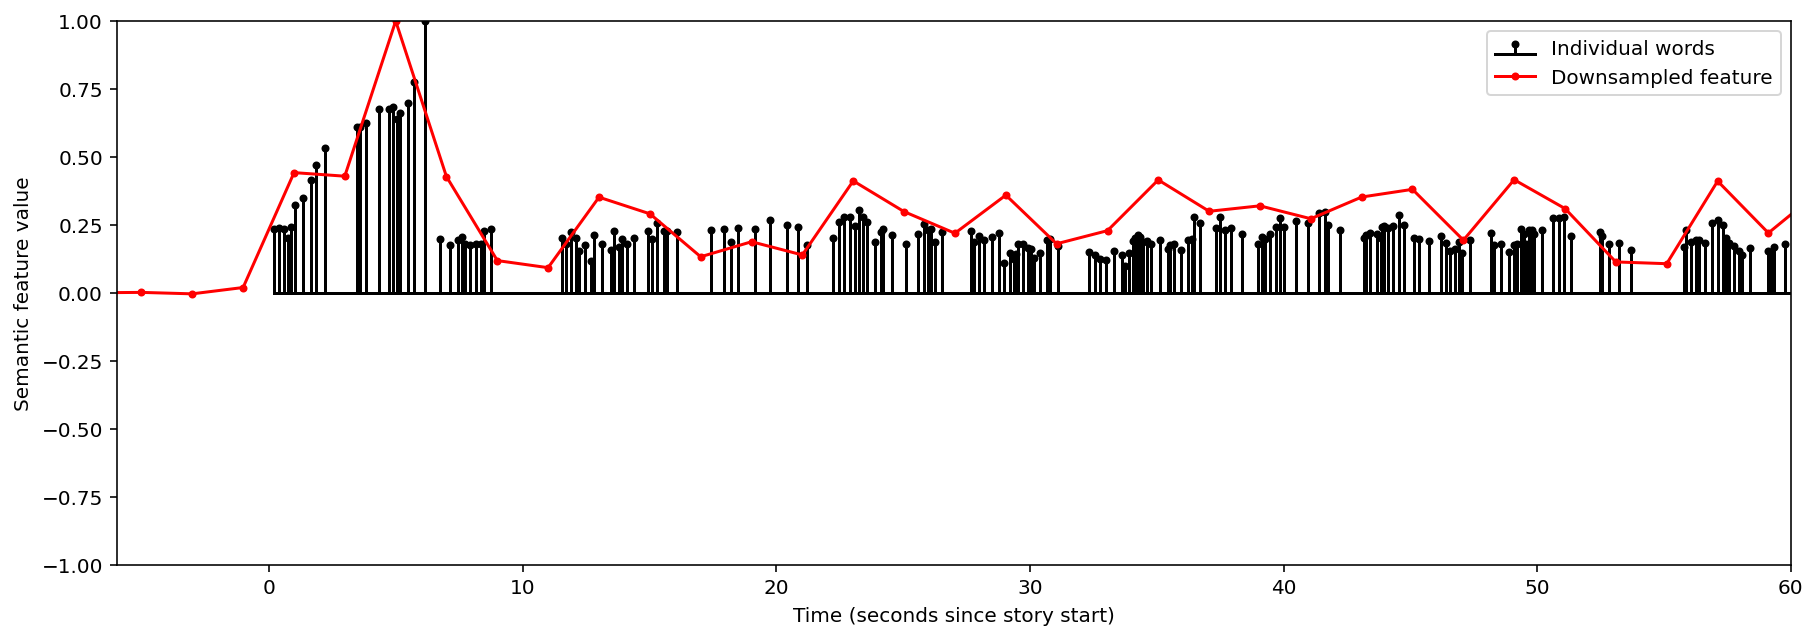

In [32]:
s_words = wordseqs["naked"]
s_sem = semanticseqs["naked"]
s_semdown = downsampled_semanticseqs["naked"]

f = figure(figsize=(15,5))
f.clf()
schan = 2
ax = f.add_subplot(1,1,1)
wordstems = ax.stem(s_words.data_times, 
                    s_sem[:,schan] / np.abs(s_sem[:,schan]).max(), 
                    linefmt="k-", markerfmt="k.", basefmt="k-")
interps = ax.plot(s_words.tr_times, 
                  s_semdown[:,schan] / np.abs(s_semdown[:,schan]).max(), 'r.-')
ax.set_xlim(-6, 60)
ax.set_ylim(-1, 1)
ax.set_xlabel("Time (seconds since story start)")
ax.set_ylabel("Semantic feature value")
ax.legend((wordstems, interps[0]), ("Individual words", "Downsampled feature"));


Concatenating features across stories

In [0]:
# Combine stimuli
from npp import zscore
trim = 5
Rstim = np.vstack([zscore(downsampled_semanticseqs[story][5+trim:-trim]) for story in Rstories])
Pstim = np.vstack([zscore(downsampled_semanticseqs[story][5+trim:-trim]) for story in Pstories])

In [34]:
# Print the sizes of these matrices
print ("Rstim shape: ", Rstim.shape)
print ("Pstim shape: ", Pstim.shape)

Rstim shape:  (3737, 768)
Pstim shape:  (291, 768)


Visualizing the combined stimuli

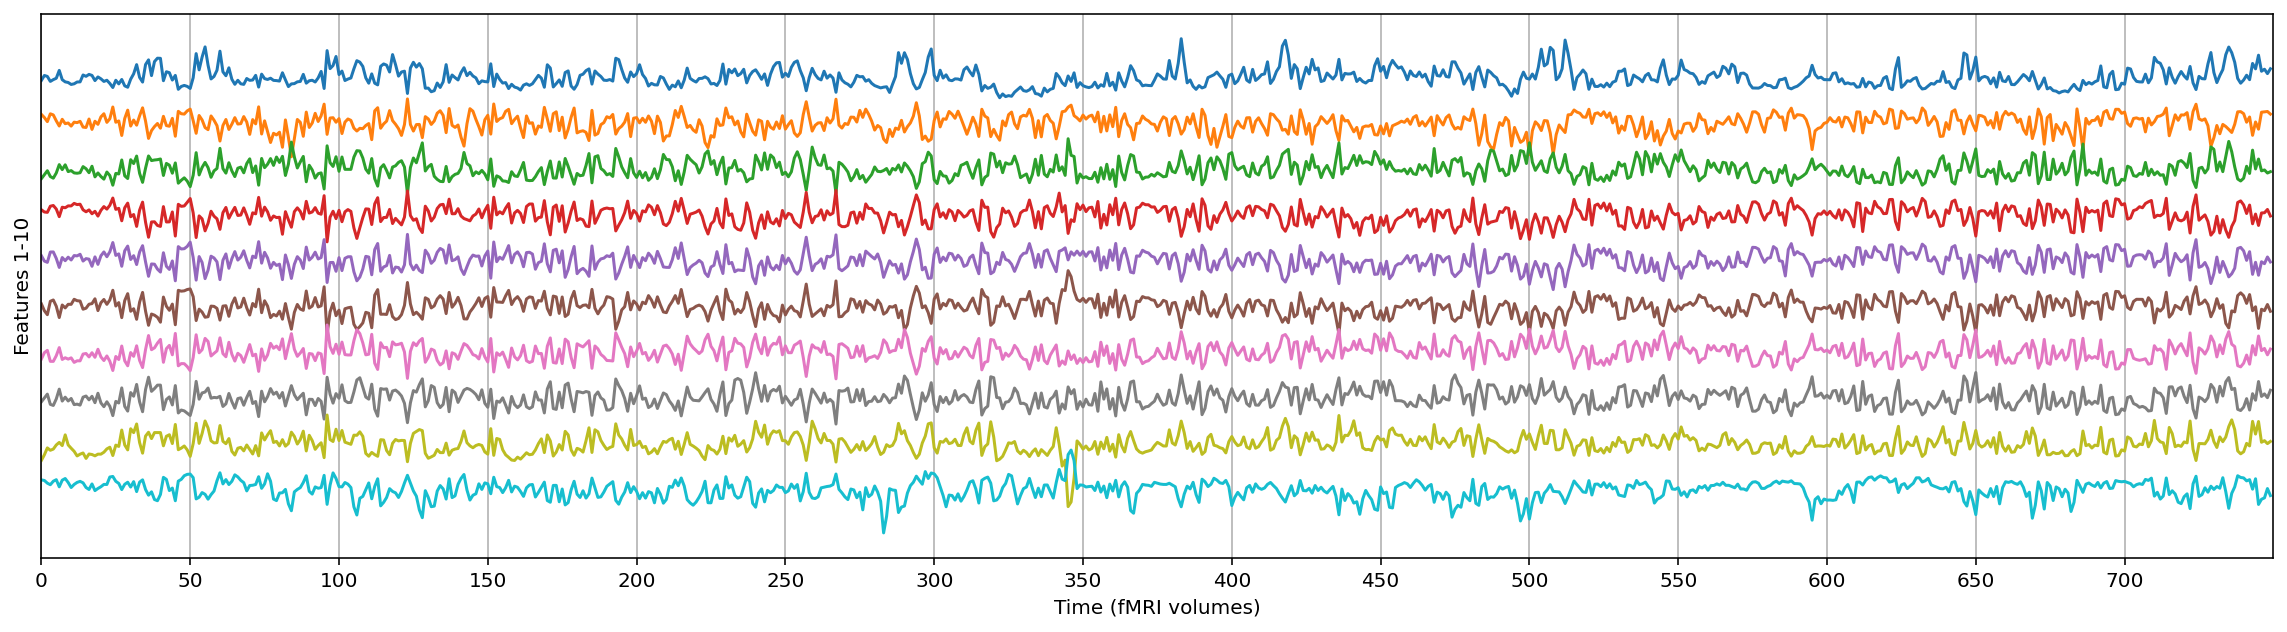

In [35]:
# Plot some of the combined stimuli
f = figure(figsize=(20, 5))
ax = f.add_subplot(1,1,1)

for ii in range(10):
    # Plot each feature, offset by 5 vertically so they are easier to see
    ax.plot(Rstim[:750,ii] - 5 * ii)

ax.set_xlim(0, 750)
ax.set_yticks([])
ax.set_xticks(range(0, 750, 50))
ax.set_xlabel("Time (fMRI volumes)")
ax.set_ylabel("Features 1-10")
ax.grid()

Concatenate delayed stimuli for FIR model

In [36]:
# Delay stimuli
from util import make_delayed
ndelays = 4
delays = range(1, ndelays+1)

print ("FIR model delays: ", delays)

delRstim = make_delayed(Rstim, delays)
delPstim = make_delayed(Pstim, delays)

INFO:numexpr.utils:Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


FIR model delays:  range(1, 5)


In [37]:
# Print the sizes of these matrices
print ("delRstim shape: ", delRstim.shape)
print ("delPstim shape: ", delPstim.shape)

delRstim shape:  (3737, 3072)
delPstim shape:  (291, 3072)


In [0]:
pickle.dump(delRstim, (open('delRstim.p', 'wb')))
pickle.dump(delPstim, (open('delPstim.p', 'wb')))

Visualizing FIR Features

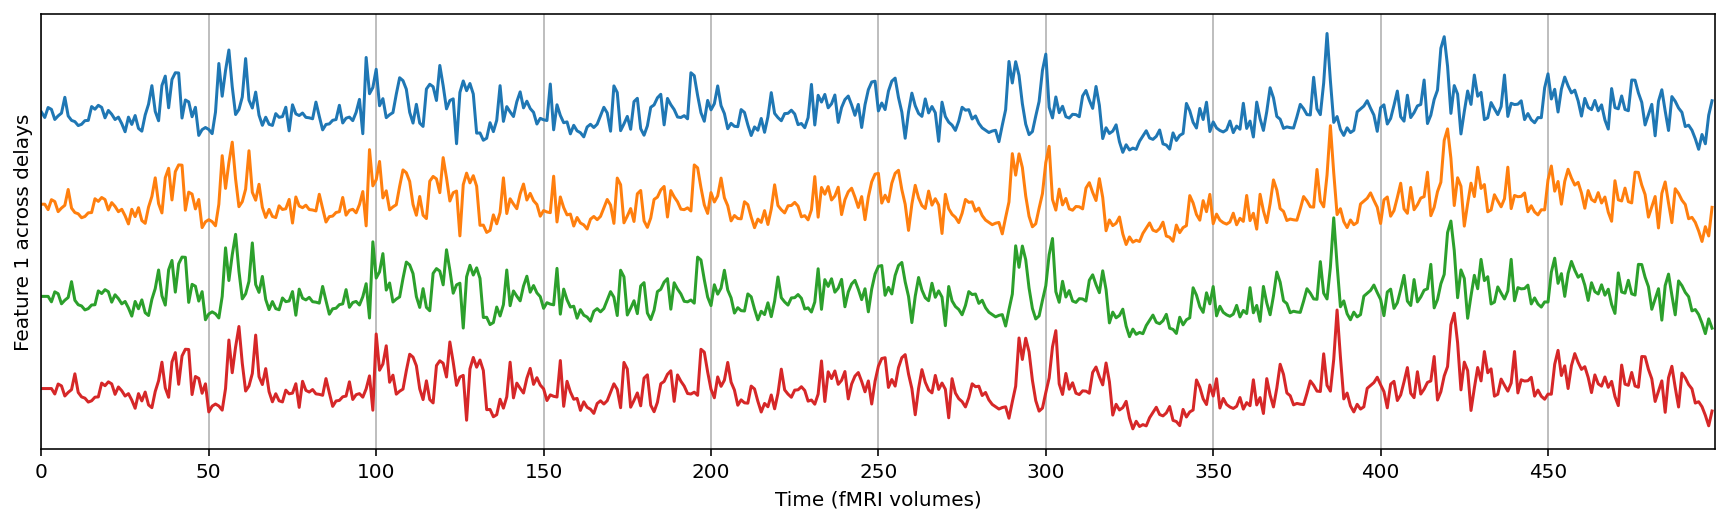

In [39]:
# Plot the same feature at different delays
f = figure(figsize=(15, 4))
ax = f.add_subplot(1,1,1)
for ii in range(ndelays):
    ax.plot(delRstim[:500, ii * Rstim.shape[1]] - 5 * ii)
ax.set_xlim(0, 500)
ax.set_yticks([])
ax.set_xticks(range(0, 500, 50))
ax.set_xlabel("Time (fMRI volumes)")
ax.set_ylabel("Feature 1 across delays")
ax.grid()

# Response Data

In [0]:
# Load responses
import tables
resptf = tables.open_file('fmri-responses.hf5')
zRresp = resptf.root.zRresp.read()
zPresp = resptf.root.zPresp.read()
mask = resptf.root.mask.read()

In [54]:
# Print matrix shapes
print ("zRresp shape (num time points, num voxels): ", zRresp.shape)
print ("zPresp shape (num time points, num voxels): ", zPresp.shape)
print ("mask shape (Z, Y, X): ", mask.shape)

zRresp shape (num time points, num voxels):  (3737, 37226)
zPresp shape (num time points, num voxels):  (291, 37226)
mask shape (Z, Y, X):  (31, 100, 100)


Visualizing the responses of few voxels over time

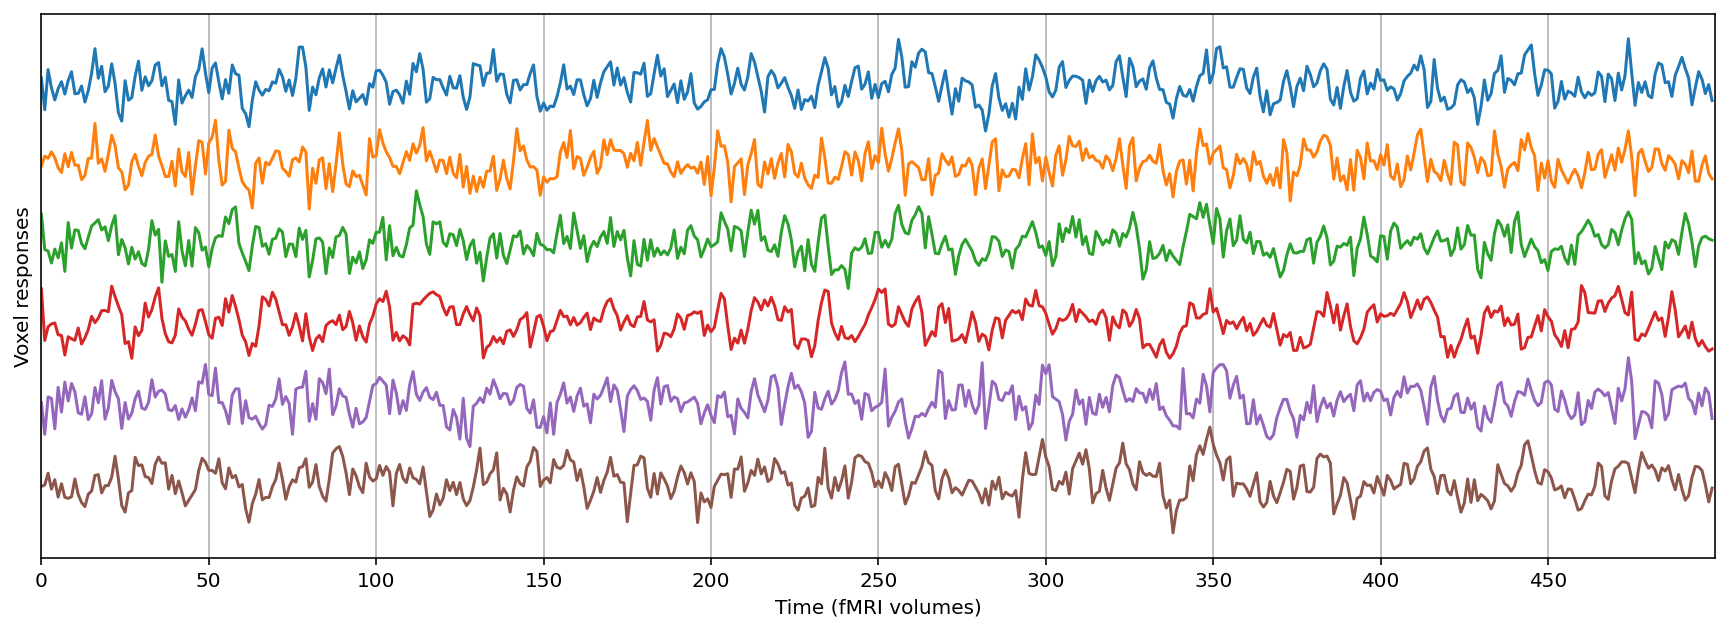

In [55]:
# Plot the response of a few voxels over time
selvoxels = [20710, 27627, 24344, 34808, 22423, 25397]

f = figure(figsize=(15, 5))
ax = f.add_subplot(1,1,1)
for ii,vi in enumerate(selvoxels):
    ax.plot(zRresp[:500, vi] - 5 * ii)
ax.set_xlim(0, 500)
ax.set_yticks([])
ax.set_xticks(range(0, 500, 50))
ax.set_xlabel("Time (fMRI volumes)")
ax.set_ylabel("Voxel responses")
ax.grid()

# Regression Model

In [43]:
# Run regression
from ridge import bootstrap_ridge
alphas = np.logspace(1, 3, 10) # Equally log-spaced alphas between 10 and 1000. The third number is the number of alphas to test.
nboots = 5 # Number of cross-validation runs.
chunklen = 40 # 
nchunks = 20

wt, corr, alphas, bscorrs, valinds = bootstrap_ridge(delRstim, zRresp, delPstim, zPresp,
                                                     alphas, nboots, chunklen, nchunks,
                                                     singcutoff=1e-10, single_alpha=True)

INFO:ridge_corr:Selecting held-out test set..
INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 1 tiny singular values.. (U is now (2937, 2936))
INFO:ridge_corr:Training stimulus has Frobenius norm: 1470.555
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.03611, max corr=0.34020, over-under(0.20)=306
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.03877, max corr=0.37485, over-under(0.20)=454
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.04210, max corr=0.40398, over-under(0.20)=618
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.04601, max corr=0.42177, over-under(0.20)=786
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.04989, max corr=0.43063, over-under(0.20)=942
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.05295, max corr=0.43442, over-under(0.20)=1053
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.05386, max corr=0.43836, over-under(0.20)=1005
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.05162, max corr=0.43414, over-under(0.20)=745


Variables returned by the regression

In [44]:
# wt is the regression weights
print ("wt has shape: ", wt.shape)

# corr is the correlation between predicted and actual voxel responses in the Prediction dataset
print ("corr has shape: ", corr.shape)

# alphas is the selected alpha value for each voxel, here it should be the same across voxels
print ("alphas has shape: ", alphas.shape)

# bscorrs is the correlation between predicted and actual voxel responses for each round of cross-validation
# within the Regression dataset
print ("bscorrs has shape (num alphas, num voxels, nboots): ", bscorrs.shape)

# valinds is the indices of the time points in the Regression dataset that were used for each
# round of cross-validation
print ("valinds has shape: ", np.array(valinds).shape)

wt has shape:  (3072, 37226)
corr has shape:  (37226,)
alphas has shape:  (37226,)
bscorrs has shape (num alphas, num voxels, nboots):  (10, 37226, 5)
valinds has shape:  (5, 800)


Testing the regression model by predicting responses

In [45]:
# Predict responses in the Prediction dataset

# First let's refresh ourselves on the shapes of these matrices
print ("zPresp has shape: ", zPresp.shape)
print ("wt has shape: ", wt.shape)
print ("delPstim has shape: ", delPstim.shape)

zPresp has shape:  (291, 37226)
wt has shape:  (3072, 37226)
delPstim has shape:  (291, 3072)


In [46]:
# Then let's predict responses by taking the dot product of the weights and stim
pred = np.dot(delPstim, wt)

print ("pred has shape: ", pred.shape)


pred has shape:  (291, 37226)


Visualizing the predeicted and the actual responses

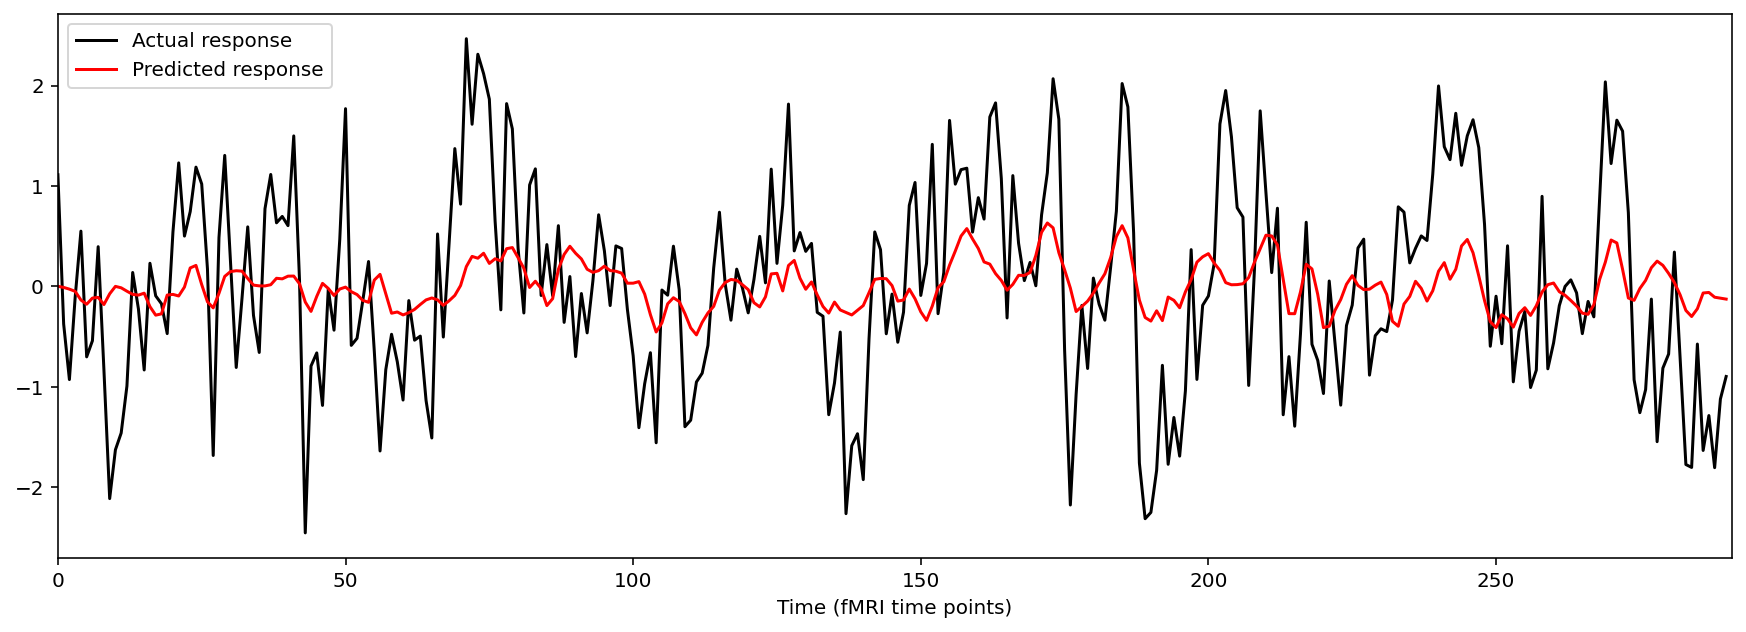

In [47]:
f = figure(figsize=(15,5))
ax = f.add_subplot(1,1,1)

selvox = 20710 # a decent voxel

realresp = ax.plot(zPresp[:,selvox], 'k')[0]
predresp = ax.plot(pred[:,selvox], 'r')[0]

ax.set_xlim(0, 291)
ax.set_xlabel("Time (fMRI time points)")

ax.legend((realresp, predresp), ("Actual response", "Predicted response"));

the predicted and actual responses look pretty different scale-wise, although the patterns of ups and downs are vaguely similar. But we don't really care about the scale -- for fMRI it's relatively arbitrary anyway, so let's rescale them both to have unit standard deviation and re-plot.

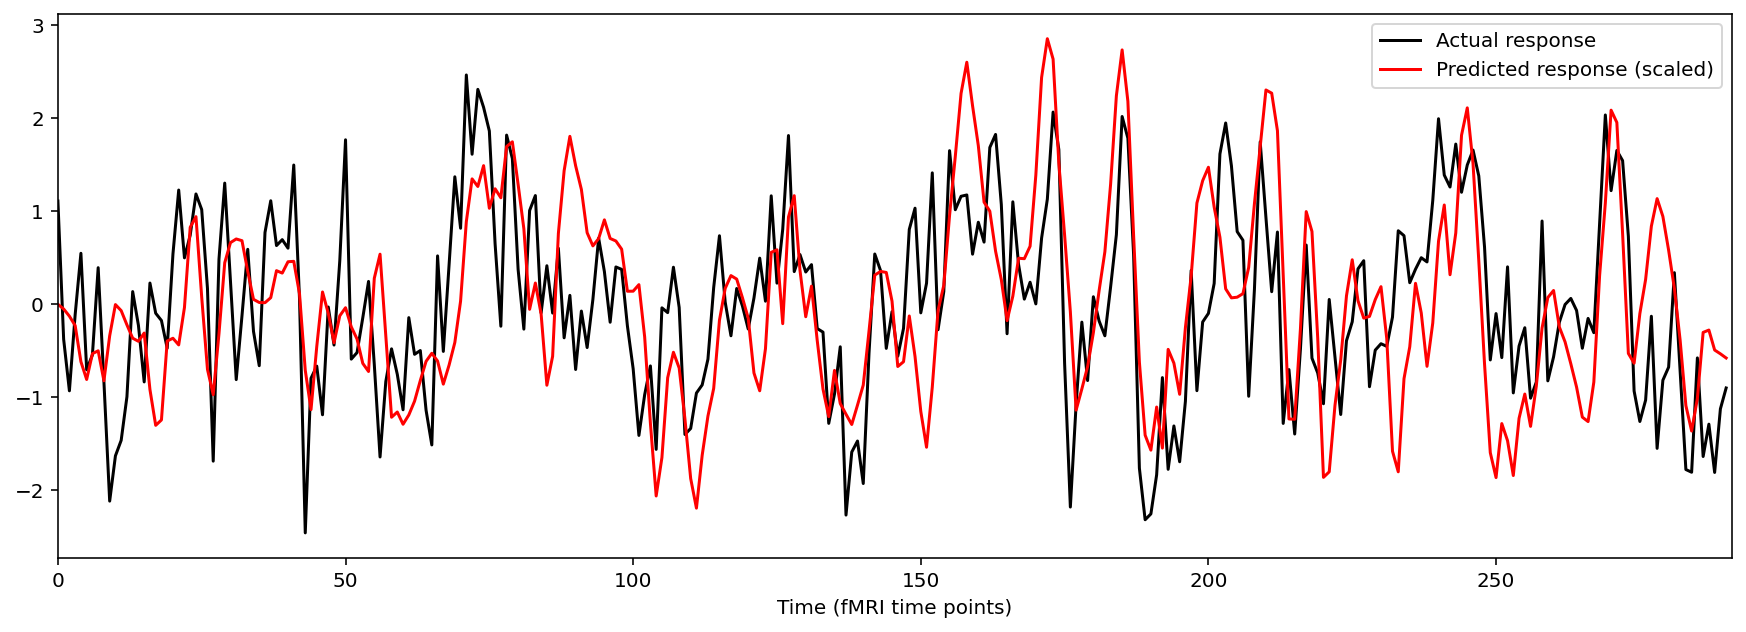

In [48]:
f = figure(figsize=(15,5))
ax = f.add_subplot(1,1,1)

selvox = 20710 # a good voxel

realresp = ax.plot(zPresp[:,selvox], 'k')[0]
predresp = ax.plot(zscore(pred[:,selvox]), 'r')[0]

ax.set_xlim(0, 291)
ax.set_xlabel("Time (fMRI time points)")

ax.legend((realresp, predresp), ("Actual response", "Predicted response (scaled)"));

In [49]:
# Compute correlation between single predicted and actual response
# (np.corrcoef returns a correlation matrix; pull out the element [0,1] to get 
# correlation between the two vectors)
voxcorr = np.corrcoef(zPresp[:,selvox], pred[:,selvox])[0,1]
print ("Correlation between predicted and actual responses for voxel %d: %f" % (selvox, voxcorr))

Correlation between predicted and actual responses for voxel 20710: 0.545127


Visualizing the correleation across the brain

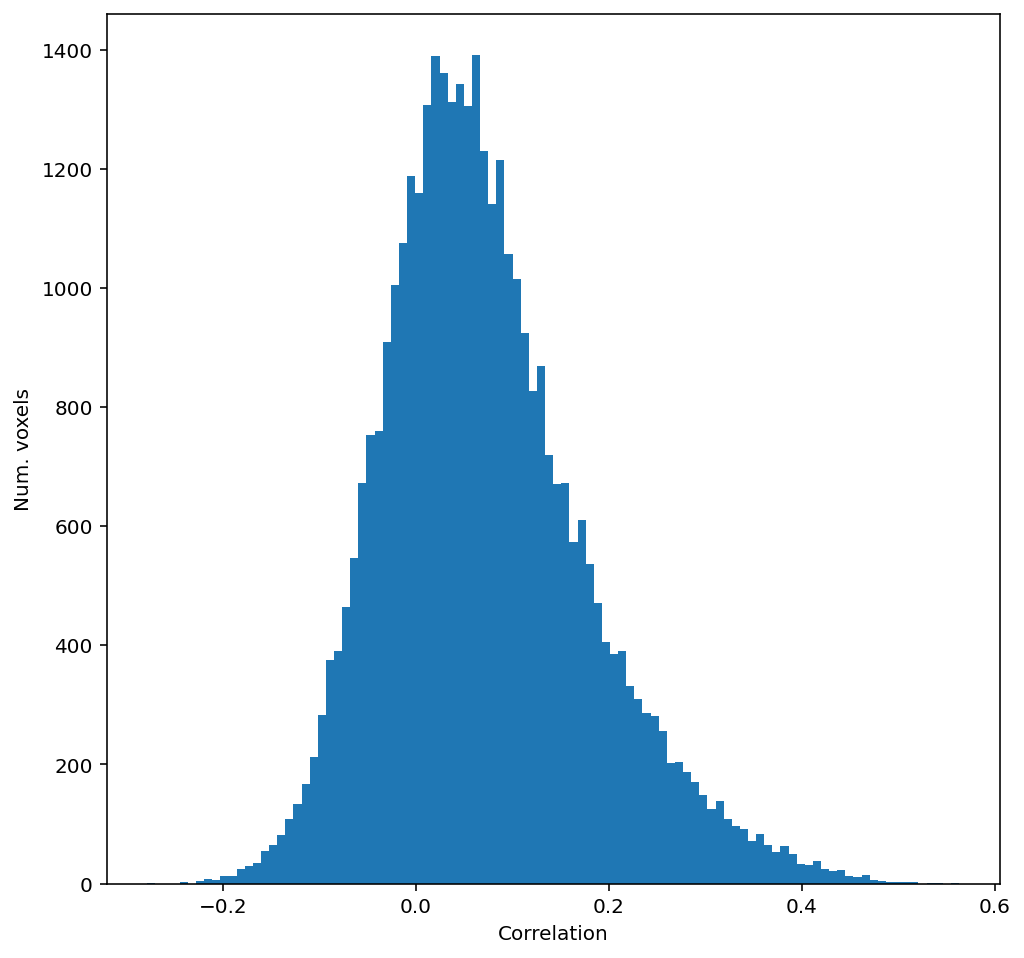

In [50]:
voxcorrs = np.zeros((zPresp.shape[1],)) # create zero-filled array to hold correlations
for vi in range(zPresp.shape[1]):
    voxcorrs[vi] = np.corrcoef(zPresp[:,vi], pred[:,vi])[0,1]

    
# Plot histogram of correlations
f = figure(figsize=(8,8))
ax = f.add_subplot(1,1,1)
ax.hist(voxcorrs, 100) # histogram correlations with 100 bins
ax.set_xlabel("Correlation")
ax.set_ylabel("Num. voxels");

In [51]:
np.mean(voxcorrs)

0.0716058067108142

Generating a flatmap cache


FileNotFoundError: ignored

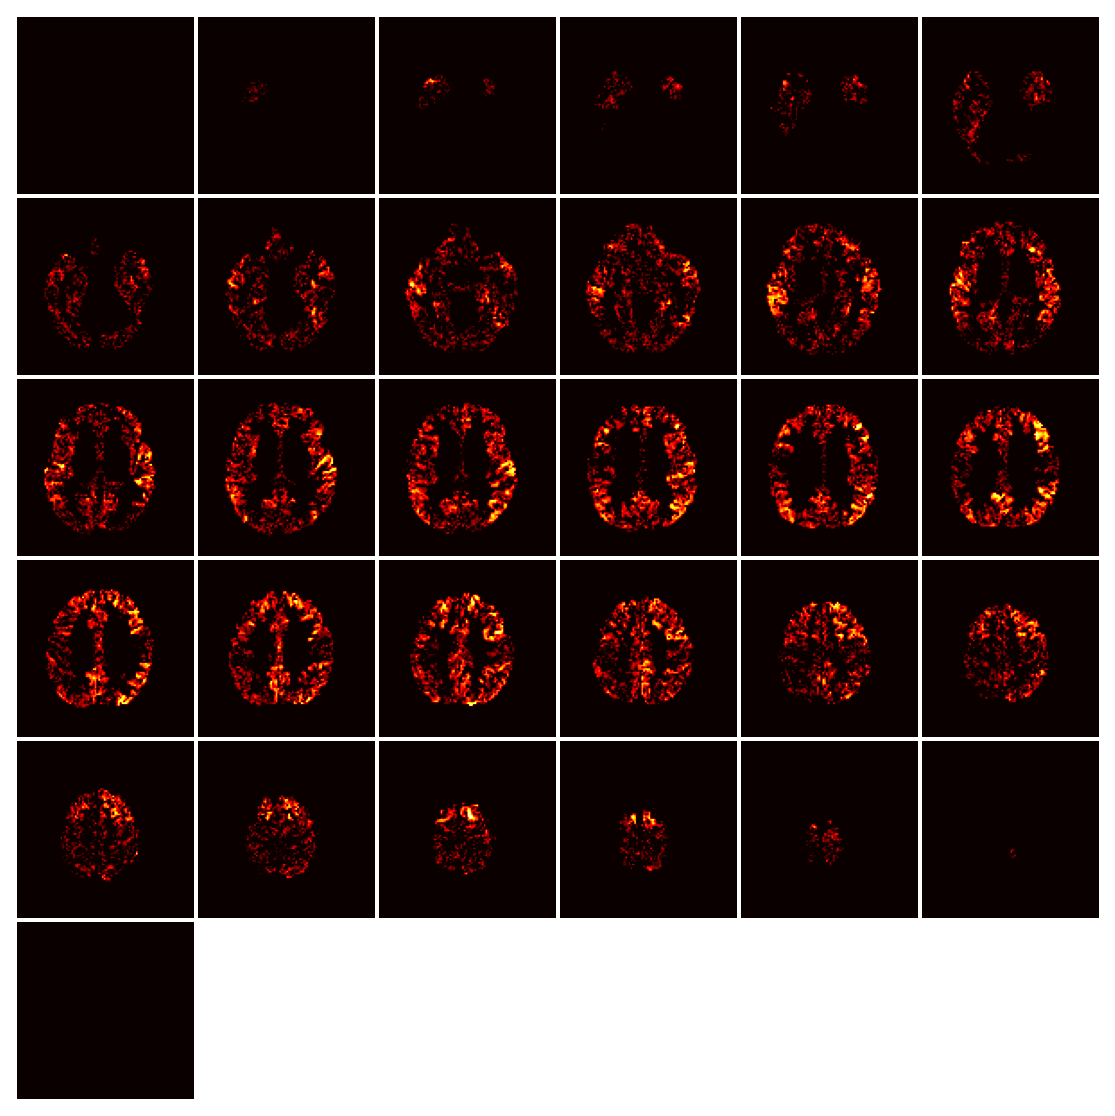

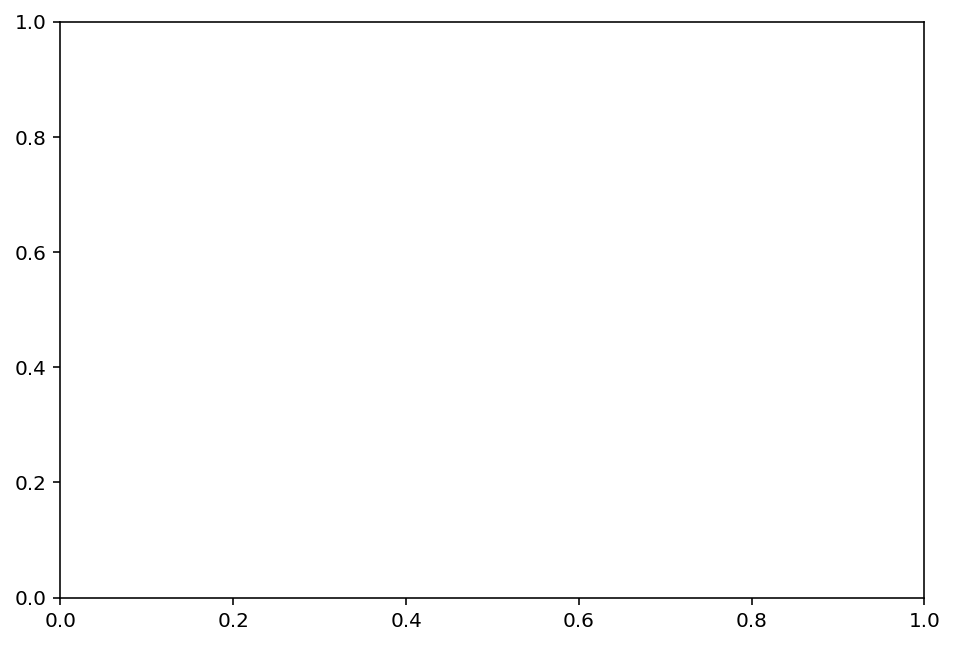

In [52]:
import cortex
# Plot mosaic of correlations
corrvolume = np.zeros(mask.shape)
corrvolume[mask>0] = voxcorrs

f = figure(figsize=(10,10))
cortex.mosaic(corrvolume, vmin=0, vmax=0.5, cmap=cm.hot);


# Plot correlations on cortex

corrvol = cortex.Volume(corr, "S1","20110321S1_auto2", mask=mask)
# corrview = cortex.quickshow(corrvol, vmin=0, vmax=0.5, cmap='hot')
#cortex.webshow(corrview, port=8889, open_browser=False) # Won't work on nbviewer
cortex.quickshow(corrvol,with_rois=False, with_labels=False)
# cortex.quickshow(corrvolume,with_rois=False, with_labels=False)
# # Plot correlation flatmap
# # cortex.quickshow(corrview, with_rois=False, with_labels=False);
# # cotex